# Solving Ricochet Robot

See https://en.wikipedia.org/wiki/Ricochet_Robot for more info

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [235]:
# Data Structures & common logic
DIMENSION = 16 # size of the board
UP, DOWN, LEFT, RIGHT = range(4) # directional enum
DIRX = [0, 0, -1, 1] # directional vectors
DIRY = [1, -1, 0, 0] # color vectors
RED, BLUE, GREEN, PURPLE = range(4)
COLORS = ['red','blue','green','purple']

def normalize_wall(x, y, direction):
    'walls are normalized to "down" or "left"'
    if direction == UP:
        direction = DOWN
        y += 1
    elif direction == RIGHT:
        direction = LEFT
        x += 1
    return (x, y, direction)

def compute_delta(robots1, robots2):
    # computes delta between two positioning of robots. Assume that exactly one robot is moved.
    # return (color, (x, y), (x, y))
    # this logic is used to construct robot paths.
    for idx in range(len(COLORS)):
        if robots1[idx] != robots2[idx]:
            return (idx, robots1[idx], robots2[idx])

class Board(object):
    def __init__(self):
        # bottom left of grid is 0, 0
        self.walls = set() # list of walls - (x, y, (DOWN|LEFT))
        
    def add_wall(self, x, y, direction):
        """Add a wall to the current position"""
        self.walls.add(normalize_wall(x, y, direction))
        
    def has_wall(self, x, y, direction):
        """Determine whether there's a wall in the given position."""
        return normalize_wall(x, y, direction) in self.walls

def next_moves(board, robots, only=None):
    """Generate list of next moves by moving a single robot."""
    def generate(index, replaced_robot):
        return tuple((replaced_robot if i == index else r) for (i, r) in enumerate(robots))
    for index, robot in enumerate(robots):
        if only is not None and not index == only: continue
        for direction in range(4):
            (x, y) = robot
            moved = False
            while True:
                newx = x + DIRX[direction]
                newy = y + DIRY[direction]
                # stops when a wall or another robot is encountered.
                if board.has_wall(x, y, direction) or (newx, newy) in robots:
                    if moved: yield generate(index, (x, y))
                    break
                moved = True
                x = newx
                y = newy
                
def prev_locations(position, board, blockers):
    # return all previous locations
    for direction in range(4):
        pass
    pass

In [182]:
# Tree Traversal Algorithm
import heapq

MAX_DEPTH = 30

class Stat(object):
    def __init__(self):
        self.iteration = 0
        self.distance = -1
        
    def __repr__(self):
        return repr(self.__dict__)
        
def astar(
    start,
    neighbour,
    finish_condition,
    heuristic=None,
    stat=None):
    """
    Perform an A* search.
    finish_condition = (position) -> bool
    heuristic = A* heuristic function. (new position, old position) -> distance
    """
    queue = [] # contains (distance+heuristic, distance, position, old_position)
    heapq.heappush(queue, (0, 0, start, None))
    history = {} # position -> (distance, previous)
    if not stat: stat = Stat()
    if not heuristic: heuristic = lambda new, old: 0
    while queue:
        stat.iteration += 1
        _, distance, position, prev_position = heapq.heappop(queue)
        if distance > MAX_DEPTH:
            return
        if finish_condition(position):
            positions = [position, prev_position]
            cur_position = prev_position
            while cur_position in history:
                cur_position = history[cur_position][1]
                if cur_position is not None:
                    positions.append(cur_position)
            stat.distance = distance
            return positions
        if position in history:
            continue
        else:
            history[position] = (distance, prev_position)
        new_distance = distance + 1
        for new_position in neighbour(position):
            heapq.heappush(queue, (new_distance + heuristic(position, new_position), new_distance, new_position, position))

In [220]:
def print_board(board, robots,
                paths=None,
                additionals=None,
                labels=None,
                finish=None):
    '''
    Print the given board position.
    robots - 4-tuple of pair (x, y), representing red, blue, green, and yellow robots.
    paths - list of (color, (x, y), (x, y)) paths to draw.
    additionals - list of (color, (x, y)) points to draw.
    labels - list of labels to render.
    '''
    plt.figure(figsize=(5, 5))
    axis = plt.gca()
    MARGIN = 0.1
    PADDING = 0.5
    def plot_robot(index, coord, size):
        (x, y) = coord
        circle = plt.Circle((x + 0.5, y + 0.5), size, fc=COLORS[i])
        axis.add_patch(circle)
    def render_wall(wall):
        (x1, y1, direction) = wall
        if direction == DOWN:
            x2 = x1 + 1
            y2 = y1
        else:
            x2 = x1
            y2 = y1 + 1
        line = plt.Line2D((x1, x2), (y1, y2), lw=2.5, color='black')
        axis.add_line(line)
    def render_path(path):
        (i, pos1, pos2) = path
        line = plt.Line2D(
            (pos1[0] + 0.5, pos2[0] + 0.5),
            (pos1[1] + 0.5, pos2[1] + 0.5),
            color=COLORS[i],
            marker='x')
        axis.add_line(line)
    for wall in board.walls: render_wall(wall)
    for path in (paths or []): render_path(path)
    for additional in (additionals or []):
        (i, robot) = additional
        plot_robot(i, robot, 0.1)
    if finish is not None:
        (i, coord) = finish
        (row, col) = coord
        rectangle = plt.Rectangle((row + MARGIN, col + MARGIN),
                                  1 - MARGIN * 2,
                                  1 - MARGIN * 2,
                                  fc=COLORS[i])
        axis.add_patch(rectangle)
    plt.xlim(0 - PADDING, DIMENSION + PADDING)
    plt.ylim(0 - PADDING, DIMENSION + PADDING)
    for i in range(len(COLORS)):
        plot_robot(i, robots[i], 0.4)
    if labels is not None:
        for row_idx, row in enumerate(labels):
            for col_idx, cell in enumerate(row):
                axis.text(col_idx + 0.5, row_idx + 0.5, cell, verticalalignment='center', horizontalalignment='center')
    plt.show()

In [221]:
# Sample Board
# TODO - randomly generate this
# got idea from http://1.bp.blogspot.com/-Ythx5IaMAxY/UPrGdgymTUI/AAAAAAAAHzY/3qHS2Hp9tkw/s1600/006-Ricochet+Robot.JPG
board = Board()
for i in range(DIMENSION):
    board.add_wall(0, i, LEFT)
    board.add_wall(i, 0, DOWN)
    board.add_wall(DIMENSION, i, LEFT)
    board.add_wall(i, DIMENSION, DOWN)
walls = [
  (0, 5, DOWN), (0, 9, DOWN),
  (1, 12, RIGHT), (1, 12, UP), (1, 2, DOWN), (1, 2, LEFT),
  (2, 10, DOWN), (2, 10, RIGHT),
  (3, 6, DOWN), (3, 6, RIGHT),
  (4, 15, LEFT),
  (5, 0, LEFT), (5, 11, LEFT), (5, 11, UP), (5, 4, LEFT), (5, 4, UP),
  (6, 1, RIGHT), (6, 1, UP), (6, 14, DOWN), (6, 14, LEFT),
  (7, 10, DOWN), (7, 10, RIGHT), (7, 7, DOWN), (7, 7, LEFT), (7, 8, LEFT), (7, 8, UP),
  (8, 7, DOWN), (8, 7, RIGHT), (8, 8, RIGHT), (8, 8, UP),
  (9, 3, LEFT), (9, 3, UP),
  (10, 15, LEFT), (10, 8, RIGHT), (10, 8, UP),
  (11, 1, DOWN), (11, 1, RIGHT), (11, 13, DOWN), (11, 13, LEFT),
  (12, 6, RIGHT), (12, 6, UP),
  (13, 9, DOWN), (13, 9, RIGHT),
  (14, 0, LEFT), (14, 14, LEFT), (14, 14, UP), (14, 2, DOWN), (14, 2, LEFT),
  (15, 12, DOWN), (15, 6, DOWN),
]
for wall in walls:
    board.add_wall(*wall)
robots = ((0, 1), (4, 1), (7, 14), (12, 4))

In [231]:
def run_and_plot(finish, heuristic=None, neighbour=None):
    """run the board."""
    stat = Stat()
    deltas = set()
    if neighbour is None: neighbour = lambda position : next_moves(board, position)    
    finish_color, finish_position = finish
    def finish_function(position): return finish_position == position[finish_color]
    positions = astar(robots, neighbour, finish_condition=finish_function, heuristic=heuristic, stat=stat)
    if positions is not None:
        for i in range(len(positions) - 1):
            deltas.add(compute_delta(positions[i + 1], positions[i]))
    print_board(board, robots, deltas, finish=finish)
    return stat

def prefer_moving_main(color, weight=1):
    # note: weight > 1, then inadmissible
    def heuristic(new, old):
        return 0 if (compute_delta(new, old)[0] == color) else weight
    return heuristic

def make_heuristic(coord, board):
    # TODO
    pass

# Introduction

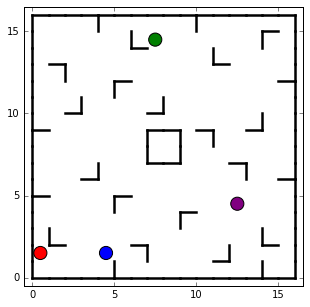

In [219]:
# starting board position
print_board(board, robots)

In [234]:
only_red = lambda coord: next_moves(board, coord, only=RED)
# all valid first move
def compute(position, deltas, depth = 1):
    if depth == 0: return
    for new_position in next_moves(board, position, only=RED):
        deltas.add(compute_delta(position, new_position))
        compute(new_position, deltas, depth - 1)
deltas = set()
compute(robots, deltas)
print_board(board, robots, paths=deltas)

NameError: name 'self' is not defined

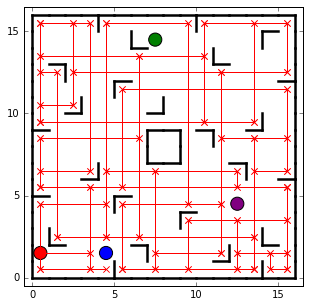

In [228]:
# all valid depth 3 moves
deltas = set()
compute(robots, deltas, depth=12)
print_board(board, robots, paths=deltas)

# Sample Interactions

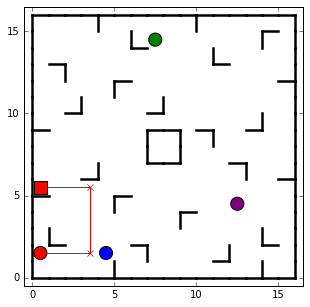

{'iteration': 1227, 'distance': 3}

In [195]:
# A simple run
run_and_plot((0, (0, 5)))

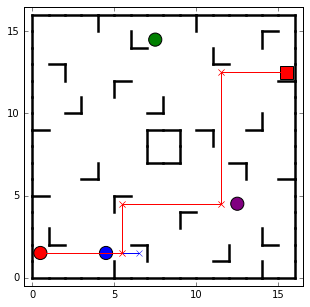

{'iteration': 74052, 'distance': 6}

In [196]:
# More complciated run - running without a heuristic function
run_and_plot((0, (15, 12)))

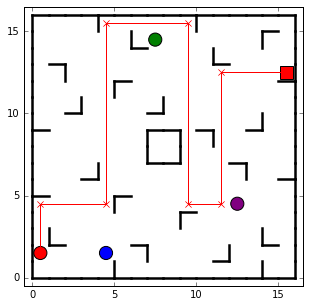

{'iteration': 106, 'distance': 8}

In [197]:
run_and_plot((RED, (15, 12)), neighbour=only_red)

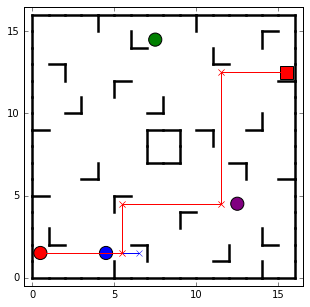

{'iteration': 36621, 'distance': 6}

In [105]:
# with heuristic - prefer moving the main robot - reduces # of moves by 1/2
run_and_plot((RED, (15, 12)), prefer_moving_main(RED))

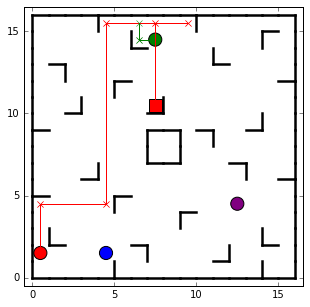

{'iteration': 258724, 'distance': 8}

In [36]:
# A complicated run
# without -> with heuristic = 457741 -> 258724 iterations
run_and_plot((0, (7, 10)), prefer_moving_main(0, 1))

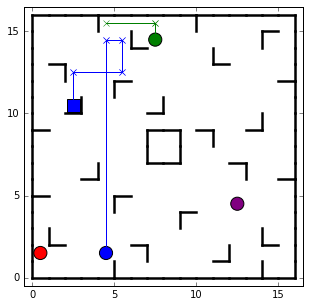

{'iteration': 78416, 'distance': 7}

In [58]:
# another example
run_and_plot((1, (2, 10)), prefer_moving_main(1))

# Inadmissible Heuristic

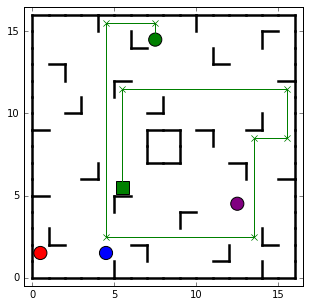

{'iteration': 511919, 'distance': 9}

In [59]:
# Simple run. requires 0.5M iterations
run_and_plot((2, (5, 5)), prefer_moving_main(2))

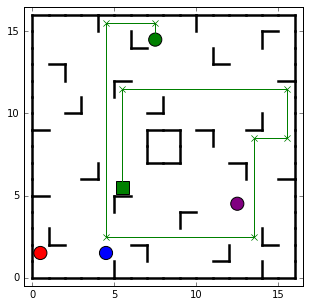

{'iteration': 288347, 'distance': 9}

In [60]:
# inadmissible heuristic but same result - only 288347 iterations
run_and_plot((2, (5, 5)), prefer_moving_main(2, 2))

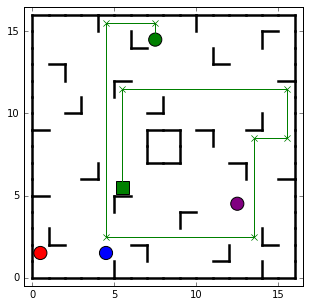

{'iteration': 45829, 'distance': 9}

In [61]:
# "very" inadmissible heuristic but fast.
# if we know that an optimal solution doesn't move other robots,
# we still achieve an optimal solution with prefer_moving_main.
# only 45829 iterations.
run_and_plot((2, (5, 5)), prefer_moving_main(2, 5))

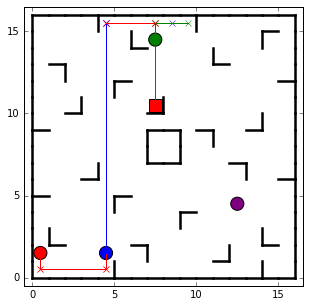

{'iteration': 79171, 'distance': 9}

In [62]:
# heavily prefer moving main.
# 258724 -> 79171, but recached a solution with distance 9 instead of 8.
run_and_plot((0, (7, 10)), prefer_moving_main(0, 4))

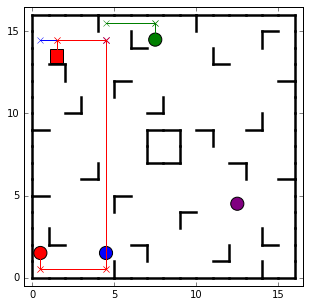

{'iteration': 550090, 'distance': 9}

In [63]:
run_and_plot((0, (1, 13)), prefer_moving_main(0))

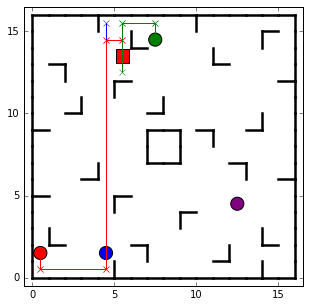

{'iteration': 605943, 'distance': 9}

In [66]:
run_and_plot((0, (5, 13)), prefer_moving_main(0))

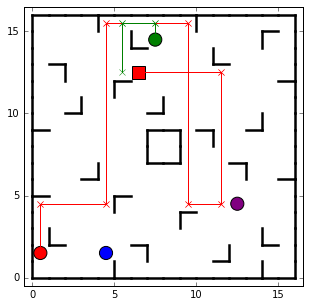

{'iteration': 957059, 'distance': 11}

In [236]:
run_and_plot((RED, (6, 12)), prefer_moving_main(RED, 3))